# Sample 2

In [1]:
from astropy.io import fits
from matplotlib import pyplot as plt
import sys
import os
import math
import logging
import galsim
import random

In [50]:
def main(argv):
    cat_file_name = os.path.join('input','galsim_default_input.asc')
    if not os.path.isdir('output'):
        os.mkdir('output')
    psf_file_name = os.path.join('output','demo_psf.fits')
    gal_file_name = os.path.join('output','demo.fits')

    random_seed = 8241573
    sky_level = 1.e6                # ADU / arcsec^2
    pixel_scale = 1.0               # arcsec / pixel  (size units in input catalog are pixels)
    gal_flux = 1.e6                 # arbitrary choice, makes nice (not too) noisy images
    gal_g1 = -0.009                 #
    gal_g2 = 0.011                  #

    # the fraction of flux in each component
    # 40% is in the bulge, 60% in a disk.  70% of that disk light is placed
    # into point sources distributed as a random walk

    bulge_frac       = 0.4
    disk_frac        = 0.6
    knot_frac        = 0.42
    smooth_disk_frac = 0.18

    # number of knots of star formation.  To simulate a nice irregular (all the
    # flux is in knots) we find ~100 is a minimum number needed, but we will
    # just use 10 here to make the demo run fast.

    n_knots = 10

    xsize = 64                      # pixels
    ysize = 64                      # pixels
    x_boundary = xsize*10-1
    y_boundary = ysize*10-1
    # Read in the input catalog
    cat = galsim.Catalog(cat_file_name)

    gal_image = galsim.ImageF(x_boundary , y_boundary,
                              scale=pixel_scale)
    psf_image = galsim.ImageF(x_boundary , y_boundary, scale=pixel_scale)
    
    for k in range(cat.nobjects):
        rng = galsim.BaseDeviate(random_seed+k+1)
        b_centerx = random.randint(32,x_boundary-32)
        b_centery = random.randint(32,y_boundary-32)
        b = galsim.BoundsI(b_centerx-32, b_centerx+32, b_centery-32, b_centery+32)
        sub_gal_image = gal_image[b]
        sub_psf_image = psf_image[b]
        beta = cat.getFloat(k,0)
        # A Moffat's size may be either scale_radius, fwhm, or half_light_radius.
        # Here we use fwhm, taking from the catalog as well.
        fwhm = cat.getFloat(k,1)
        # A Moffat profile may be truncated if desired
        # The units for this are expected to be arcsec (or specifically -- whatever units
        # you are using for all the size values as defined by the pixel_scale).
        trunc = cat.getFloat(k,4)
        # Note: You may omit the flux, since the default is flux=1.
        psf = galsim.Moffat(beta=beta, fwhm=fwhm, trunc=trunc)

        # Take the (e1, e2) shape parameters from the catalog as well.
        psf = psf.shear(e1=cat.getFloat(k,2), e2=cat.getFloat(k,3))

        # Galaxy is a bulge + disk(+knots) with parameters taken from the catalog:

        # put some fraction of the disk light into knots of star formation

        disk_hlr = cat.getFloat(k,5)
        disk_e1 = cat.getFloat(k,6)
        disk_e2 = cat.getFloat(k,7)
        bulge_hlr = cat.getFloat(k,8)
        bulge_e1 = cat.getFloat(k,9)
        bulge_e2 = cat.getFloat(k,10)

        smooth_disk = galsim.Exponential(flux=smooth_disk_frac, half_light_radius=disk_hlr)

        knots = galsim.RandomWalk(n_knots, half_light_radius=disk_hlr, flux=knot_frac, rng=rng)

        disk = galsim.Add([smooth_disk, knots])
        disk = disk.shear(e1=disk_e1, e2=disk_e2)

        # the rest of the light goes into the bulge
        bulge = galsim.DeVaucouleurs(flux=bulge_frac, half_light_radius=bulge_hlr)
        bulge = bulge.shear(e1=bulge_e1, e2=bulge_e2)

        # The flux of an Add object is the sum of the component fluxes.
        # Note that in demo3.py, a similar addition was performed by the binary operator "+".
        gal = galsim.Add([disk, bulge])

        # This flux may be overridden by withFlux.  The relative fluxes of the components
        # remains the same, but the total flux is set to gal_flux.
        gal = gal.withFlux(gal_flux)
        gal = gal.shear(g1=gal_g1, g2=gal_g2)

        # The center of the object is normally placed at the center of the postage stamp image.
        # You can change that with shift:
        gal = gal.shift(dx=cat.getFloat(k,11), dy=cat.getFloat(k,12))

        final = galsim.Convolve([psf, gal])

        # Draw the profile
        final.drawImage(sub_gal_image)

        # Add Poisson noise to the image:
        sub_gal_image.addNoise(galsim.PoissonNoise(rng, sky_level * pixel_scale**2))
   
        psf.drawImage(sub_psf_image)
    
    # Now write the images to a multi-extension fits file.  Each image will be in its own HDU.
    gal_image.write(gal_file_name)
    psf_image.write(psf_file_name)


if __name__ == "__main__":
    main(sys.argv)

Filename: output/demo.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      20   (639, 639)   float32   


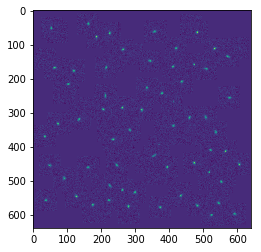

In [53]:
fits_image= fits.open('output/demo.fits')
fits_image.info()
data = fits_image[0].data
plt.imshow(data)

Filename: output/demo_psf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      20   (639, 639)   float32   


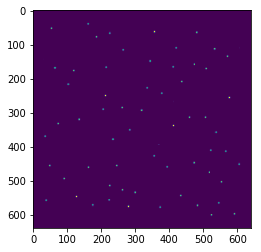

In [52]:
fits_image= fits.open('output/demo_psf.fits')
fits_image.info()
data_psf = fits_image[0].data
plt.imshow(data_psf)